In [7]:
import warnings;
warnings.filterwarnings('ignore');

In [1]:
import pandas as pd
from my_utils import loader
import os
import pymc3 as pm
import arviz as az
import pickle
import numpy as np

In [2]:
quest_before = pd.read_csv("datasets/EyeT/Questionnaire_datasetIA.csv")
quest_before.index.name = "Participant"
quest_before.head()

,Participant nr,NR,Created,Modified,Consent,Q1,Q2,Q3,Q4,Q5,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Total Score extended,Total Score original,Elapsed time
Participant,,,,,,,,,,,,,,,,,,,,,
1,9199452,07.09.2020 15:13,07.09.2020 15:13,Yes,Proceed,3,3,4,4,3,...,1,4,4,4,1,3,4,134,108,5 minutes 5 seconds
2,9584002,30.09.2020 11:23,30.09.2020 11:23,Yes,Proceed,3,3,4,4,4,...,2,4,3,3,4,2,2,133,105,5 minutes 55 seconds
3,9112363,02.09.2020 09:17,02.09.2020 09:17,Yes,Proceed,2,2,3,4,3,...,3,3,3,3,3,3,3,116,81,6 minutes 49 seconds
4,9727754,06.10.2020 13:20,06.10.2020 13:20,Yes,Proceed,2,3,4,3,2,...,2,3,4,4,2,4,2,114,96,8 minutes 39 seconds
5,9730232,06.10.2020 14:53,06.10.2020 14:53,Yes,Proceed,3,3,4,4,3,...,1,4,2,1,4,4,4,138,106,7 minutes 27 seconds


In [3]:
REGRESSOR_FIX = [
    "B_drift_00_mean",
    "B_drift_11_mean", 
    "B_cross_mean",
    "B_drift_00_sd", 
    "B_drift_11_sd",
    "B_cross_sd", 
    "Sigma_00_mean",
    "Sigma_11_mean",
    "Sigma_cross_mean",
    "Sigma_00_sd",
    "Sigma_11_sd",
    "Sigma_cross_sd",
    "fdur",
    "left_pupil",
    "right_pupil"
]

In [4]:
REGRESSOR_SAC = [
    "B_drift_00_mean",
    "B_drift_11_mean",
    "B_cross_mean",
    "B_drift_00_sd",
    "B_drift_11_sd",
    "B_cross_sd",
    "Sigma_00_mean",
    "Sigma_11_mean",
    "Sigma_cross_mean",
    "Sigma_00_sd",
    "Sigma_11_sd",
    "Sigma_cross_sd",
    "angle",
    "amplitude",
    "duration"
]

## __Free viewing__

<AxesSubplot: >

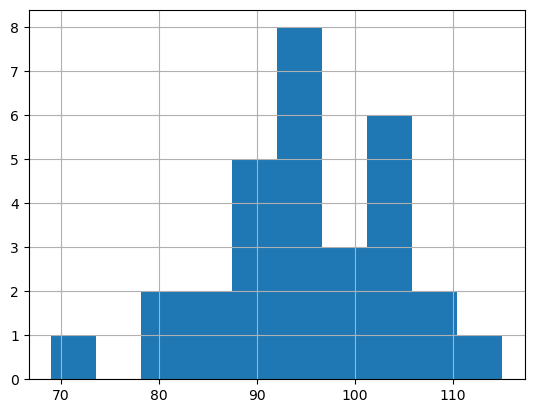

In [5]:
free_viewing_empathy = quest_before[quest_before.index%2 == 0]["Total Score original"]
free_viewing_empathy.hist()

### __Fixations__

In [10]:
AGGREGATED_PATH = "output/aggregated_features/"

def get_fix_free_features(sub_nr, dset="train"):
    with open(
        f"{AGGREGATED_PATH}/{dset}/event_features_{sub_nr:02}_agg.pickle", "rb"
    ) as f:
        fix_features = pickle.load(f)[0]
    labels = np.repeat(free_viewing_empathy[sub_nr], len(fix_features))
    return fix_features, labels

In [12]:
free_fix_train_features = []
free_fix_train_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/train/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_fix_free_features(sub_nr)
        for feature in features:
            free_fix_train_features.append(feature)
        for label in labels:
            free_fix_train_labels.append(label)

free_fix_features_train = np.array(free_fix_train_features)
free_fix_features_train = (free_fix_features_train - free_fix_features_train.min(axis=0))/(free_fix_features_train.max(axis=0)-free_fix_features_train.min(axis=0))
free_fix_labels = np.array(free_fix_train_labels)

In [37]:
from theano import tensor as T

prova_train = free_fix_features_train[:10]
prova_labels = free_fix_labels[:10]

with pm.Model() as free_fix_empathy:
    X = pm.Data("x", prova_train)
    y = pm.Data("y", prova_labels)
    a = pm.Normal("a", mu= 0, sigma=10)
    b = pm.Normal("b", mu=0, sigma=10, shape=15)

    alpha = pm.Exponential("alpha", 0.5)
    λ = pm.math.exp(a + T.dot(X, b.T))
    pm.NegativeBinomial("empathy", mu=λ, alpha=alpha, observed=y, shape = X.eval().shape[0])

    free_fix_empathy_trace = pm.sample(10, tune=500)


Sampling 4 chains for 500 tune and 10 draw iterations (2_000 + 40 draws total) took 8 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4378768315752278, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [41]:
prova_test = free_fix_features_train[5:9]

with free_fix_empathy:
    pm.set_data({"x":prova_test})
    predictions = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [43]:
predictions["empathy"]

array([[ 34, 271, 178,  62],
       [ 29,  58, 250,  99],
       [ 27, 125, 113,  58],
       [ 36,  82,  33,  79],
       [208,  83,  85, 189],
       [111,  96,  68, 136],
       [ 78,  30, 282, 106],
       [ 38, 124,  88,  77],
       [ 92,  92, 175,  71],
       [101, 120,  47,  99],
       [ 56, 367, 102,  82],
       [ 52, 168,  81,  43],
       [ 68, 221,  67,  67],
       [181,  40,  61,  44],
       [108, 103,  84, 149],
       [140,  39,  57,  45],
       [215,  58,  95,  70],
       [115, 116, 127, 104],
       [199, 519, 190, 101],
       [ 22,  51, 126,  51],
       [179, 274,  85, 138],
       [ 76, 104, 139, 182],
       [ 67, 239,  84, 156],
       [ 88, 176, 134, 104],
       [ 76,  98,  66, 111],
       [135,  91,  90, 134],
       [ 90, 250,  68, 100],
       [ 84,  77, 217, 104],
       [168, 130, 138, 145],
       [110,  69, 138, 104],
       [ 97, 102, 111,  84],
       [240,  99, 186, 163],
       [ 67, 108,  54,  88],
       [124, 140,  89, 147],
       [116, 1

In [156]:
with open("models/free_fix_empathy_10_10_05", 'wb') as buff:
    pickle.dump({'model': free_fix_empathy, 'trace': free_fix_empathy_trace}, buff)

In [157]:
free_fix_features_test = pd.DataFrame()
for filename in os.listdir("output/aggregated_features/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        free_fix_features_test = free_fix_features_test.append(get_fix_free_features(sub_nr, dset = "test"))

free_fix_features_test.iloc[:, :-1] = free_fix_features_test.apply(
    lambda c: (c - c.min()) / (c.max() - c.min()), axis=1
)
free_fix_features_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,empathy_level
0,0.040021,0.040007,0.040038,0.040019,0.040020,0.040033,1.000000,0.000000,0.377384,0.397559,0.066813,0.165005,0.040057,0.040691,0.040681,102
1,0.026720,0.026708,0.026719,0.026718,0.026714,0.026718,1.000000,0.000000,0.304103,0.473020,0.039581,0.162298,0.026715,0.026890,0.026891,102
2,0.035615,0.035598,0.035618,0.035611,0.035611,0.035615,1.000000,0.000000,0.446562,0.300793,0.057924,0.140185,0.035784,0.036301,0.036307,102
3,0.080016,0.079967,0.080144,0.080009,0.080026,0.080106,1.000000,0.000000,0.654694,0.313613,0.114069,0.217378,0.080502,0.081820,0.081797,102
4,0.013005,0.012930,0.013338,0.012997,0.013029,0.013261,0.786972,0.000000,1.000000,0.304109,0.093709,0.376072,0.013292,0.017357,0.017382,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.011923,0.011908,0.011975,0.011921,0.011926,0.011960,0.175340,0.000000,1.000000,0.065001,0.016954,0.353448,0.011935,0.012072,0.012073,89
126,0.000010,0.000000,0.000045,0.000009,0.000011,0.000039,0.224593,0.011343,1.000000,0.131835,0.008864,0.504580,0.000007,0.000172,0.000176,89
127,0.018075,0.018061,0.018127,0.018073,0.018079,0.018115,0.275861,0.000000,1.000000,0.126575,0.027802,0.412557,0.018083,0.018332,0.018327,89
128,0.011162,0.011150,0.011298,0.011162,0.011169,0.011263,0.168524,0.000000,1.000000,0.090404,0.016941,0.446579,0.011162,0.011296,0.011293,89


In [159]:
with free_fix_empathy:
    pm.set_data({"x": free_fix_features_test})
    fix_free_predictions = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [160]:
fix_free_predictions["y"].shape

(4000, 14021)

In [62]:
pois_loo = az.loo(free_fix_empathy_trace, free_fix_empathy)
pois_loo

Computed from 4000 by 14021 log-likelihood matrix

         Estimate       SE
elpd_loo -49832.99    56.12
p_loo       11.99        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     14017  100.0%
 (0.5, 0.7]   (ok)           2    0.0%
   (0.7, 1]   (bad)          1    0.0%
   (1, Inf)   (very bad)     1    0.0%

In [64]:
az.summary(free_fix_empathy_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.52,0.01,4.51,4.53,0.00,0.00,3336.12,2975.82,1.0
beta[0],0.27,0.27,-0.24,0.75,0.00,0.00,3142.14,2619.38,1.0
beta[1],6.25,6.98,-6.86,18.93,0.12,0.09,3573.20,3134.08,1.0
beta[2],1.33,4.50,-6.36,10.44,0.09,0.07,2573.15,2849.78,1.0
beta[3],-2.00,3.27,-8.27,3.84,0.06,0.05,2848.90,2518.57,1.0
beta[4],-4.84,7.75,-18.96,10.03,0.14,0.10,3153.77,2824.28,1.0
beta[5],-1.93,6.74,-14.30,10.88,0.13,0.10,2693.94,2853.67,1.0
beta[6],0.04,0.01,0.01,0.06,0.00,0.00,1548.92,2060.88,1.0
beta[7],-0.02,0.08,-0.17,0.12,0.00,0.00,5814.26,3235.77,1.0
beta[8],0.02,0.01,-0.01,0.04,0.00,0.00,1661.41,2243.66,1.0


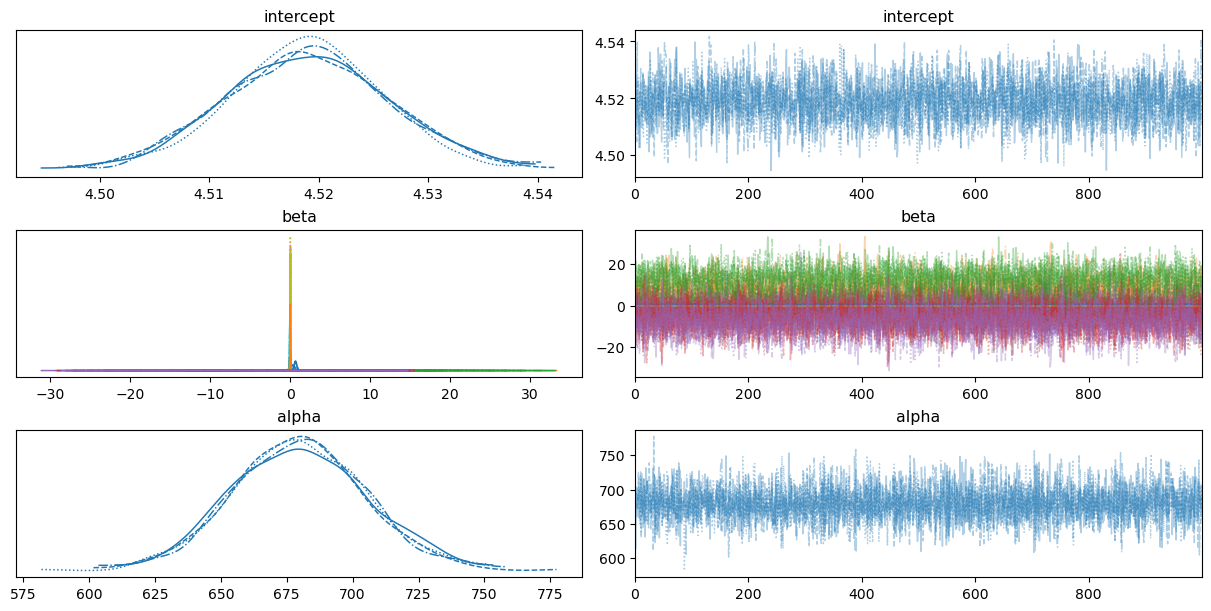

In [65]:
trace = az.plot_trace(free_fix_empathy_trace)

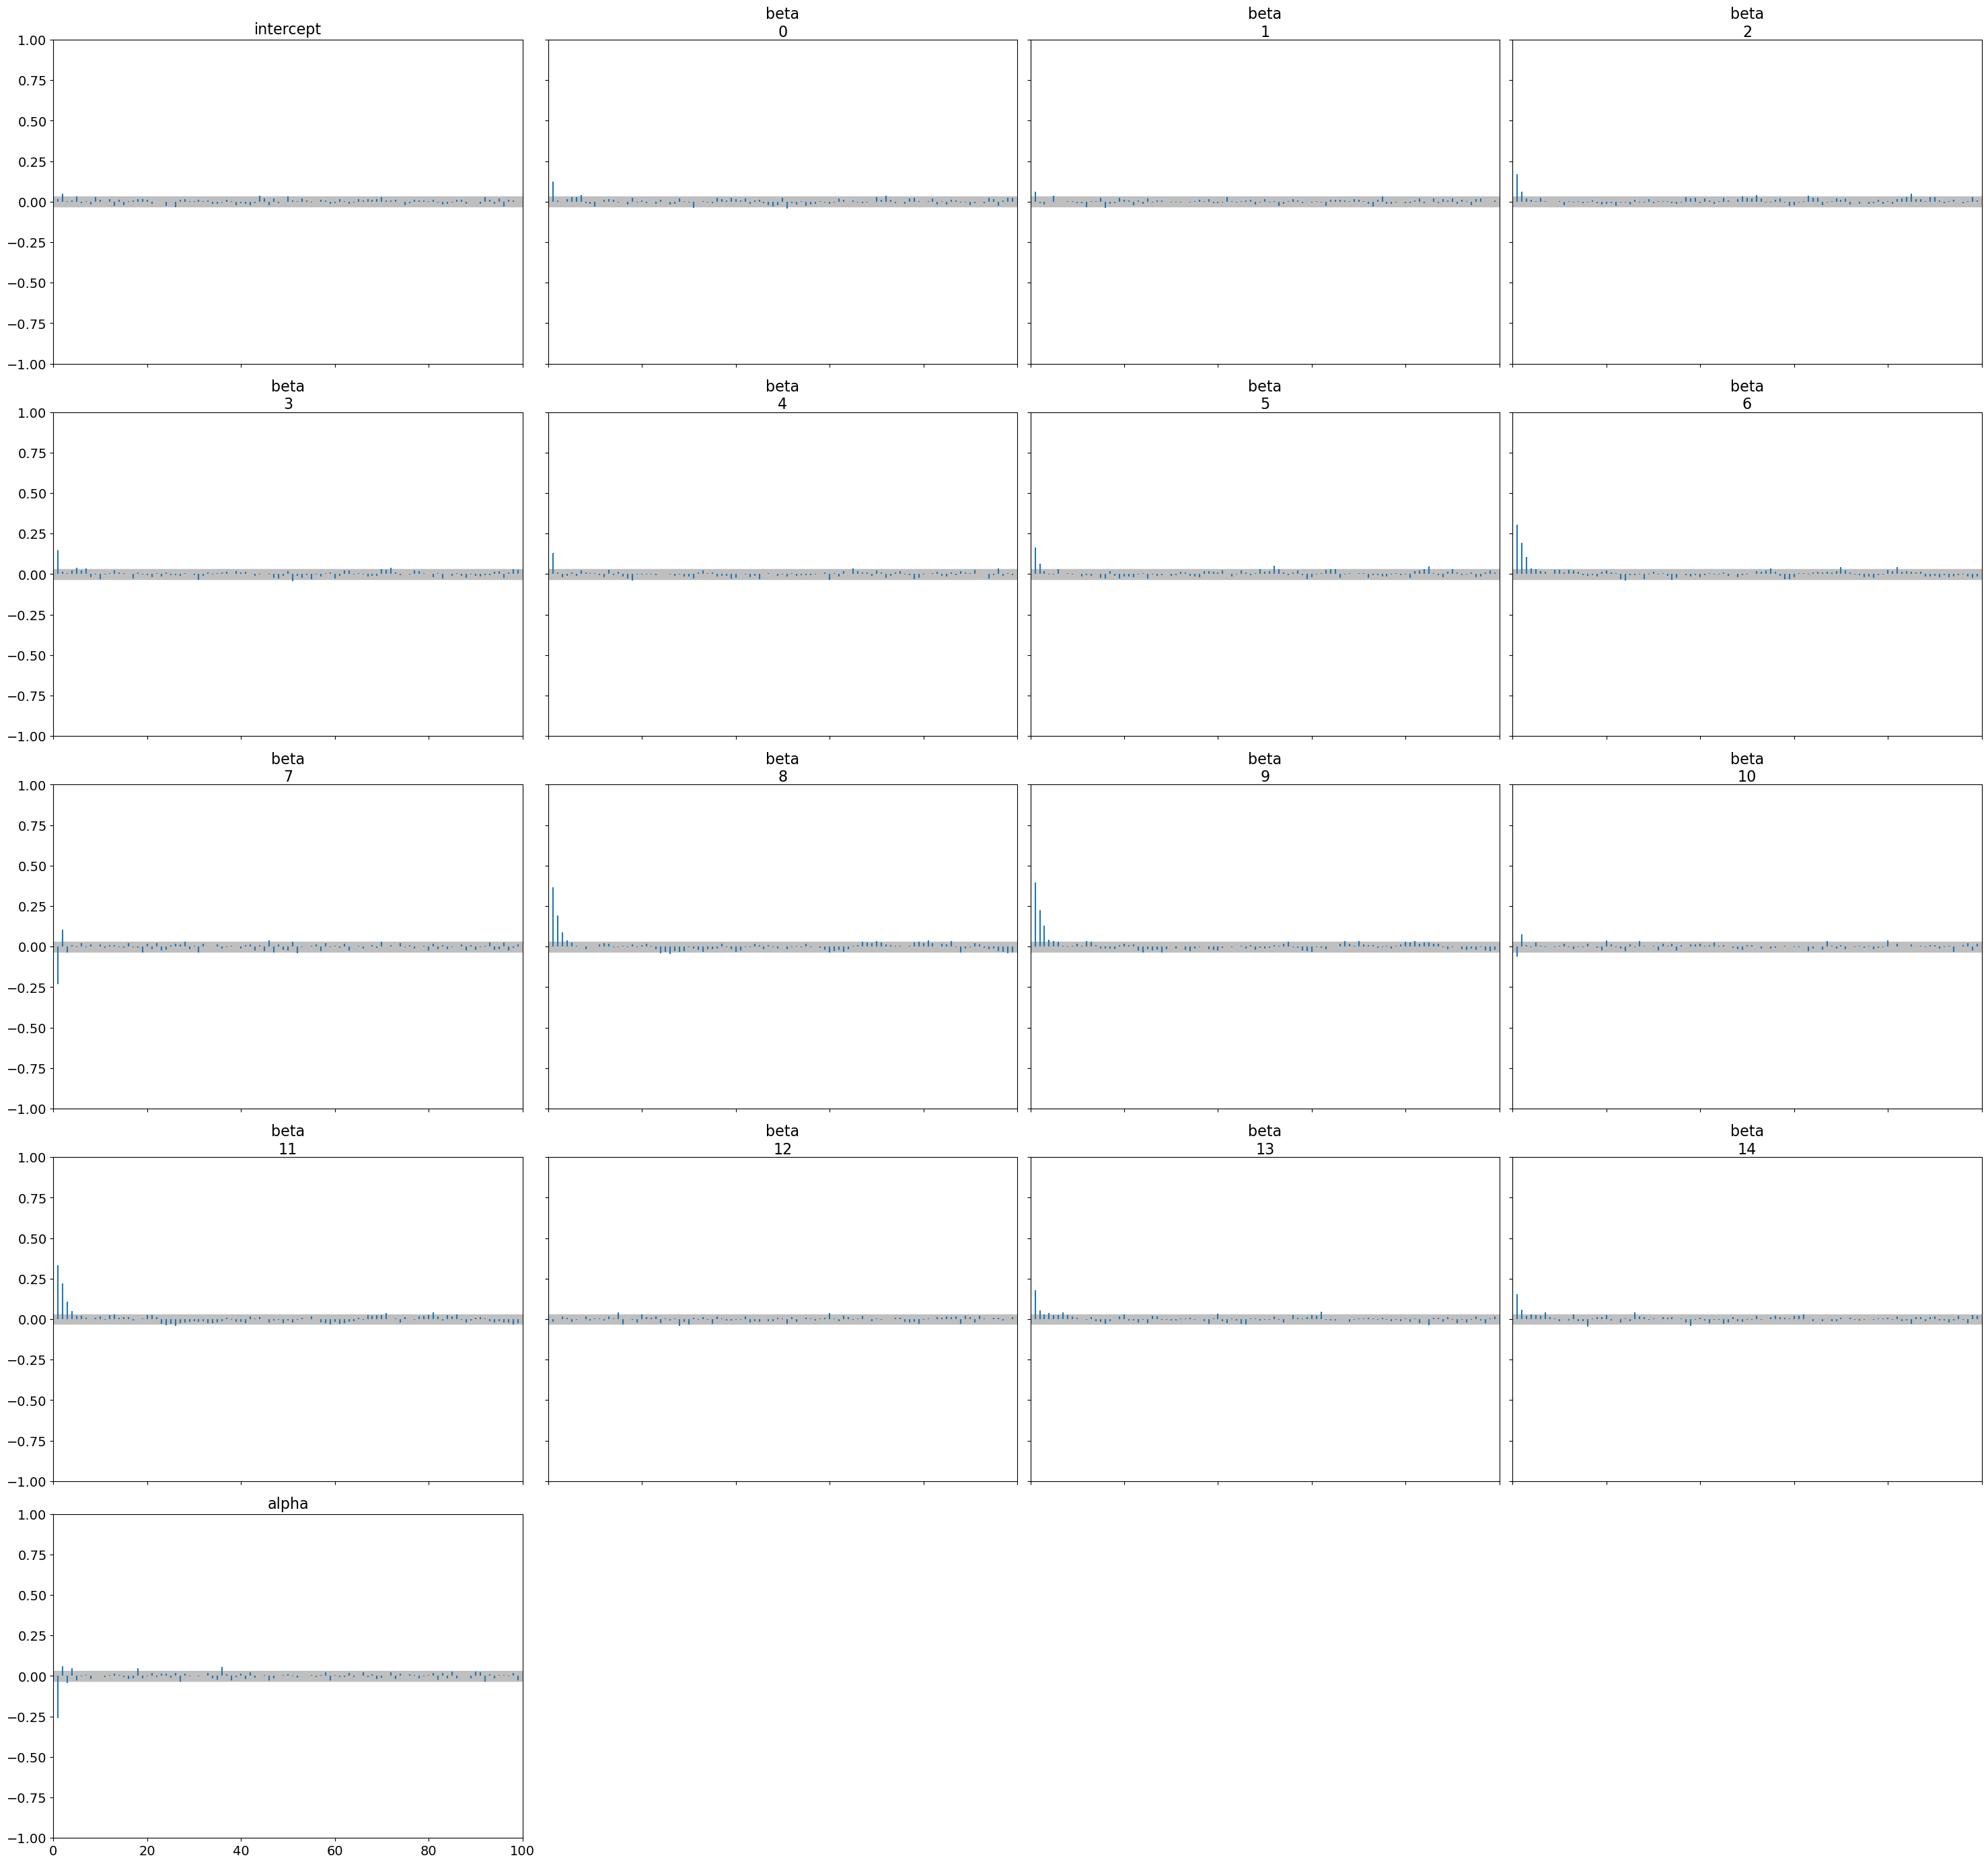

In [66]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

__Posterior predictive check__

In [67]:
with free_fix_empathy:
    fix_free_ppc = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [68]:
fix_free_ppc_data = az.from_pymc3(model=free_fix_empathy, posterior_predictive=fix_free_ppc) 
fix_free_pred_train = fix_free_ppc_data.posterior_predictive['y'].to_numpy().mean(axis=(0,1))

In [69]:
from sklearn.metrics import mean_squared_error
mean_squared_error(free_fix_train_features["empathy_level"].values, fix_free_pred_train, squared= False)

8.036319053776975

<AxesSubplot: xlabel='y'>

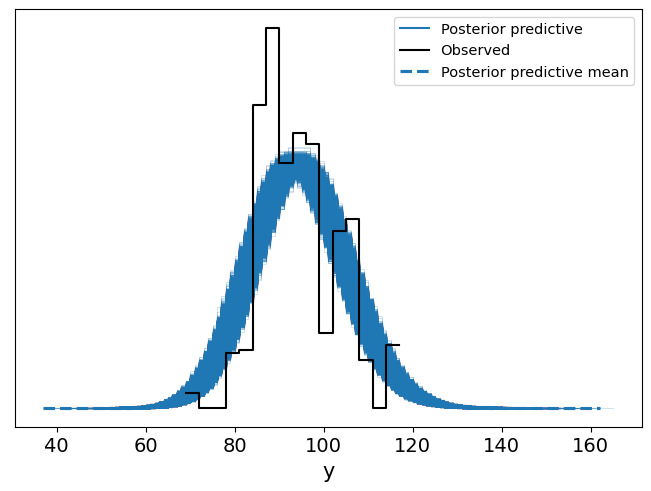

In [70]:
az.plot_ppc(fix_free_ppc_data)

__Feature selection__

In [71]:
from sklearn import feature_selection

statistics, p_values = feature_selection.f_regression(np.array(free_fix_features.loc[:, free_fix_features.columns != "empathy_level"]), fix_free_pred_train)

In [72]:
pd.Series(statistics).rename(lambda i : REGRESSOR_FIX[i]).sort_values(ascending=False)

Sigma_00_mean       15011.530118
Sigma_00_sd          5686.824690
Sigma_11_sd          3339.250157
fdur                 2477.286825
B_drift_11_sd        2466.750343
B_drift_00_sd        2461.400997
B_drift_11_mean      2459.829855
B_cross_sd           2441.710873
B_cross_mean         2419.168147
left_pupil           2354.879878
right_pupil          2351.520482
Sigma_cross_sd       1581.973039
B_drift_00_mean      1443.295683
Sigma_cross_mean      812.963998
Sigma_11_mean          16.008626
dtype: float64

In [73]:
pred_differences = free_fix_features["empathy_level"].values - fix_free_pred_train
statistics, p_values = feature_selection.f_regression(np.array(free_fix_features.loc[:, free_fix_features.columns != "empathy_level"])[np.where(pred_differences < 5)], fix_free_pred_train[np.where(pred_differences < 5)])
pd.Series(statistics).rename(lambda i : REGRESSOR_FIX[i]).sort_values(ascending=False)

Sigma_00_mean       14625.138309
Sigma_00_sd          5603.146018
Sigma_11_sd          2869.941874
fdur                 1993.997269
B_drift_11_mean      1985.454606
B_drift_11_sd        1985.408325
B_drift_00_sd        1978.309936
B_cross_sd           1970.445228
B_cross_mean         1960.336758
left_pupil           1955.346275
right_pupil          1950.981536
Sigma_cross_sd       1122.495603
B_drift_00_mean      1036.105312
Sigma_cross_mean      718.201389
Sigma_11_mean          31.702361
dtype: float64

In [74]:
pred_differences = free_fix_features["empathy_level"].values - fix_free_pred_train
statistics, p_values = feature_selection.f_regression(np.array(free_fix_features.loc[:, free_fix_features.columns != "empathy_level"])[np.where(pred_differences > 5)], fix_free_pred_train[np.where(pred_differences > 5)])
pd.Series(statistics).rename(lambda i : REGRESSOR_FIX[i]).sort_values(ascending=False)

Sigma_00_mean       2180.166194
Sigma_00_sd          689.076413
Sigma_11_sd          611.949820
fdur                 521.553675
B_drift_00_sd        520.958568
B_drift_11_sd        519.108909
B_drift_00_mean      515.593746
B_drift_11_mean      513.731756
B_cross_sd           511.133961
B_cross_mean         501.433149
right_pupil          458.885811
left_pupil           458.571800
Sigma_cross_sd       438.735566
Sigma_cross_mean     120.963371
Sigma_11_mean          0.868892
dtype: float64

### __Saccades__

In [97]:
def get_sac_free_features(sub_nr, dset = "train"):
    _, sac_features, _, _ = loader.load_event_features(f"new_long_features/{dset}/event_features_{sub_nr}.npy")
    features_db = pd.DataFrame(sac_features)
    features_db["empathy_level"] = free_viewing_empathy[sub_nr]
    return features_db

free_sac_features = pd.DataFrame()
for filename in os.listdir("new_long_features/train"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr%2 == 0:
        free_sac_features = free_sac_features.append(get_sac_free_features(sub_nr))
free_sac_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,empathy_level
0,19.924682,-20.401286,30.133434,7.096898,4.791750,7.750815,40651.994184,-909.355698,21834.606682,14086.368757,209.242610,8755.754347,123.978418,551.101624,0.050000,69
1,3.454659,-0.007308,0.627120,0.966711,0.393833,0.491530,40346.052039,823.379110,23968.950036,15954.985961,307.635407,12355.501965,-95.053826,147.573710,0.050000,69
2,14.641698,0.137735,0.188078,5.801901,0.924878,0.157543,22978.140862,-564.275658,22896.124615,8949.829022,174.679429,9352.358097,-83.290163,376.579341,0.050000,69
3,1.544659,-3.847847,10.997907,0.523657,0.724932,1.636998,49608.483049,-179.839127,3652.929669,17774.414729,128.727740,2002.078664,99.553388,620.606961,0.033333,69
4,4.162048,-0.665146,0.637022,0.935143,0.585640,0.507577,18257.356934,37.974306,14376.532979,9516.970369,254.119596,8945.140288,-76.087505,112.294256,0.033333,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.116199,-0.609161,7.154601,0.091462,0.352530,3.778192,47346.091056,-431.597828,19845.946941,17935.732975,306.381195,10337.791292,101.265135,250.832614,0.050000,102
256,0.278948,-0.069495,2.160541,0.209384,0.218632,1.792461,33053.496290,724.200020,21786.238659,16980.071431,375.186719,13245.424957,114.443955,12.083046,0.033333,102
257,6.371413,-6.106444,18.388942,1.252810,1.093959,6.080656,33810.233523,-901.777381,33896.431639,11708.089150,218.329880,13133.047953,-79.840944,351.511024,0.075000,102
258,0.114028,-0.034174,0.309801,0.091710,0.091151,0.267578,37716.711405,863.840807,33697.208137,15672.326565,336.297626,15629.039875,61.882130,148.529458,0.050000,102


In [99]:
with pm.Model() as free_sac_empathy:
    a = pm.Normal("intercept", mu= 0, sigma= 20)
    b = pm.Normal("beta", mu=0, sigma=20, shape=len(free_sac_features.columns[:-1]))

    alpha = pm.Exponential("alpha", 2)

    data = pm.Data("free_sacc_feat", free_sac_features)

    λ = pm.math.exp(a + sum([b[i]*data.eval()[:,i] for i in free_sac_features.columns[:-1]]))

    y = pm.NegativeBinomial("y", mu=λ, alpha=alpha, observed=data.eval()[:,-1])

    free_sac_empathy_trace = pm.sample(init = "adapt_diag", tune=2000)


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 126 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


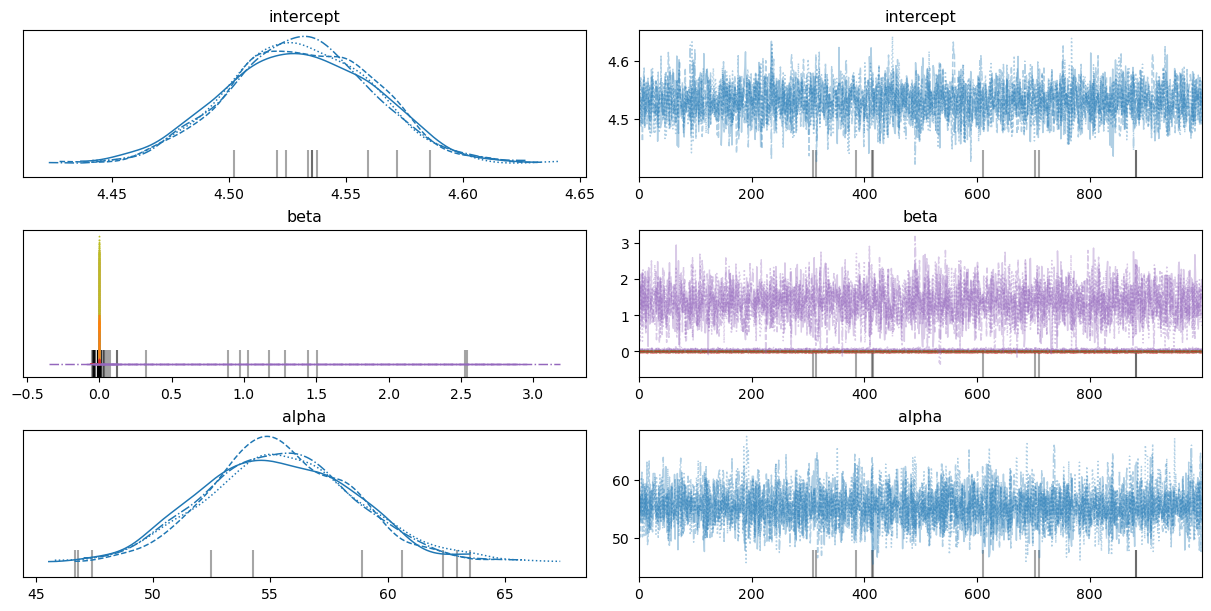

In [100]:
trace = az.plot_trace(free_sac_empathy_trace)

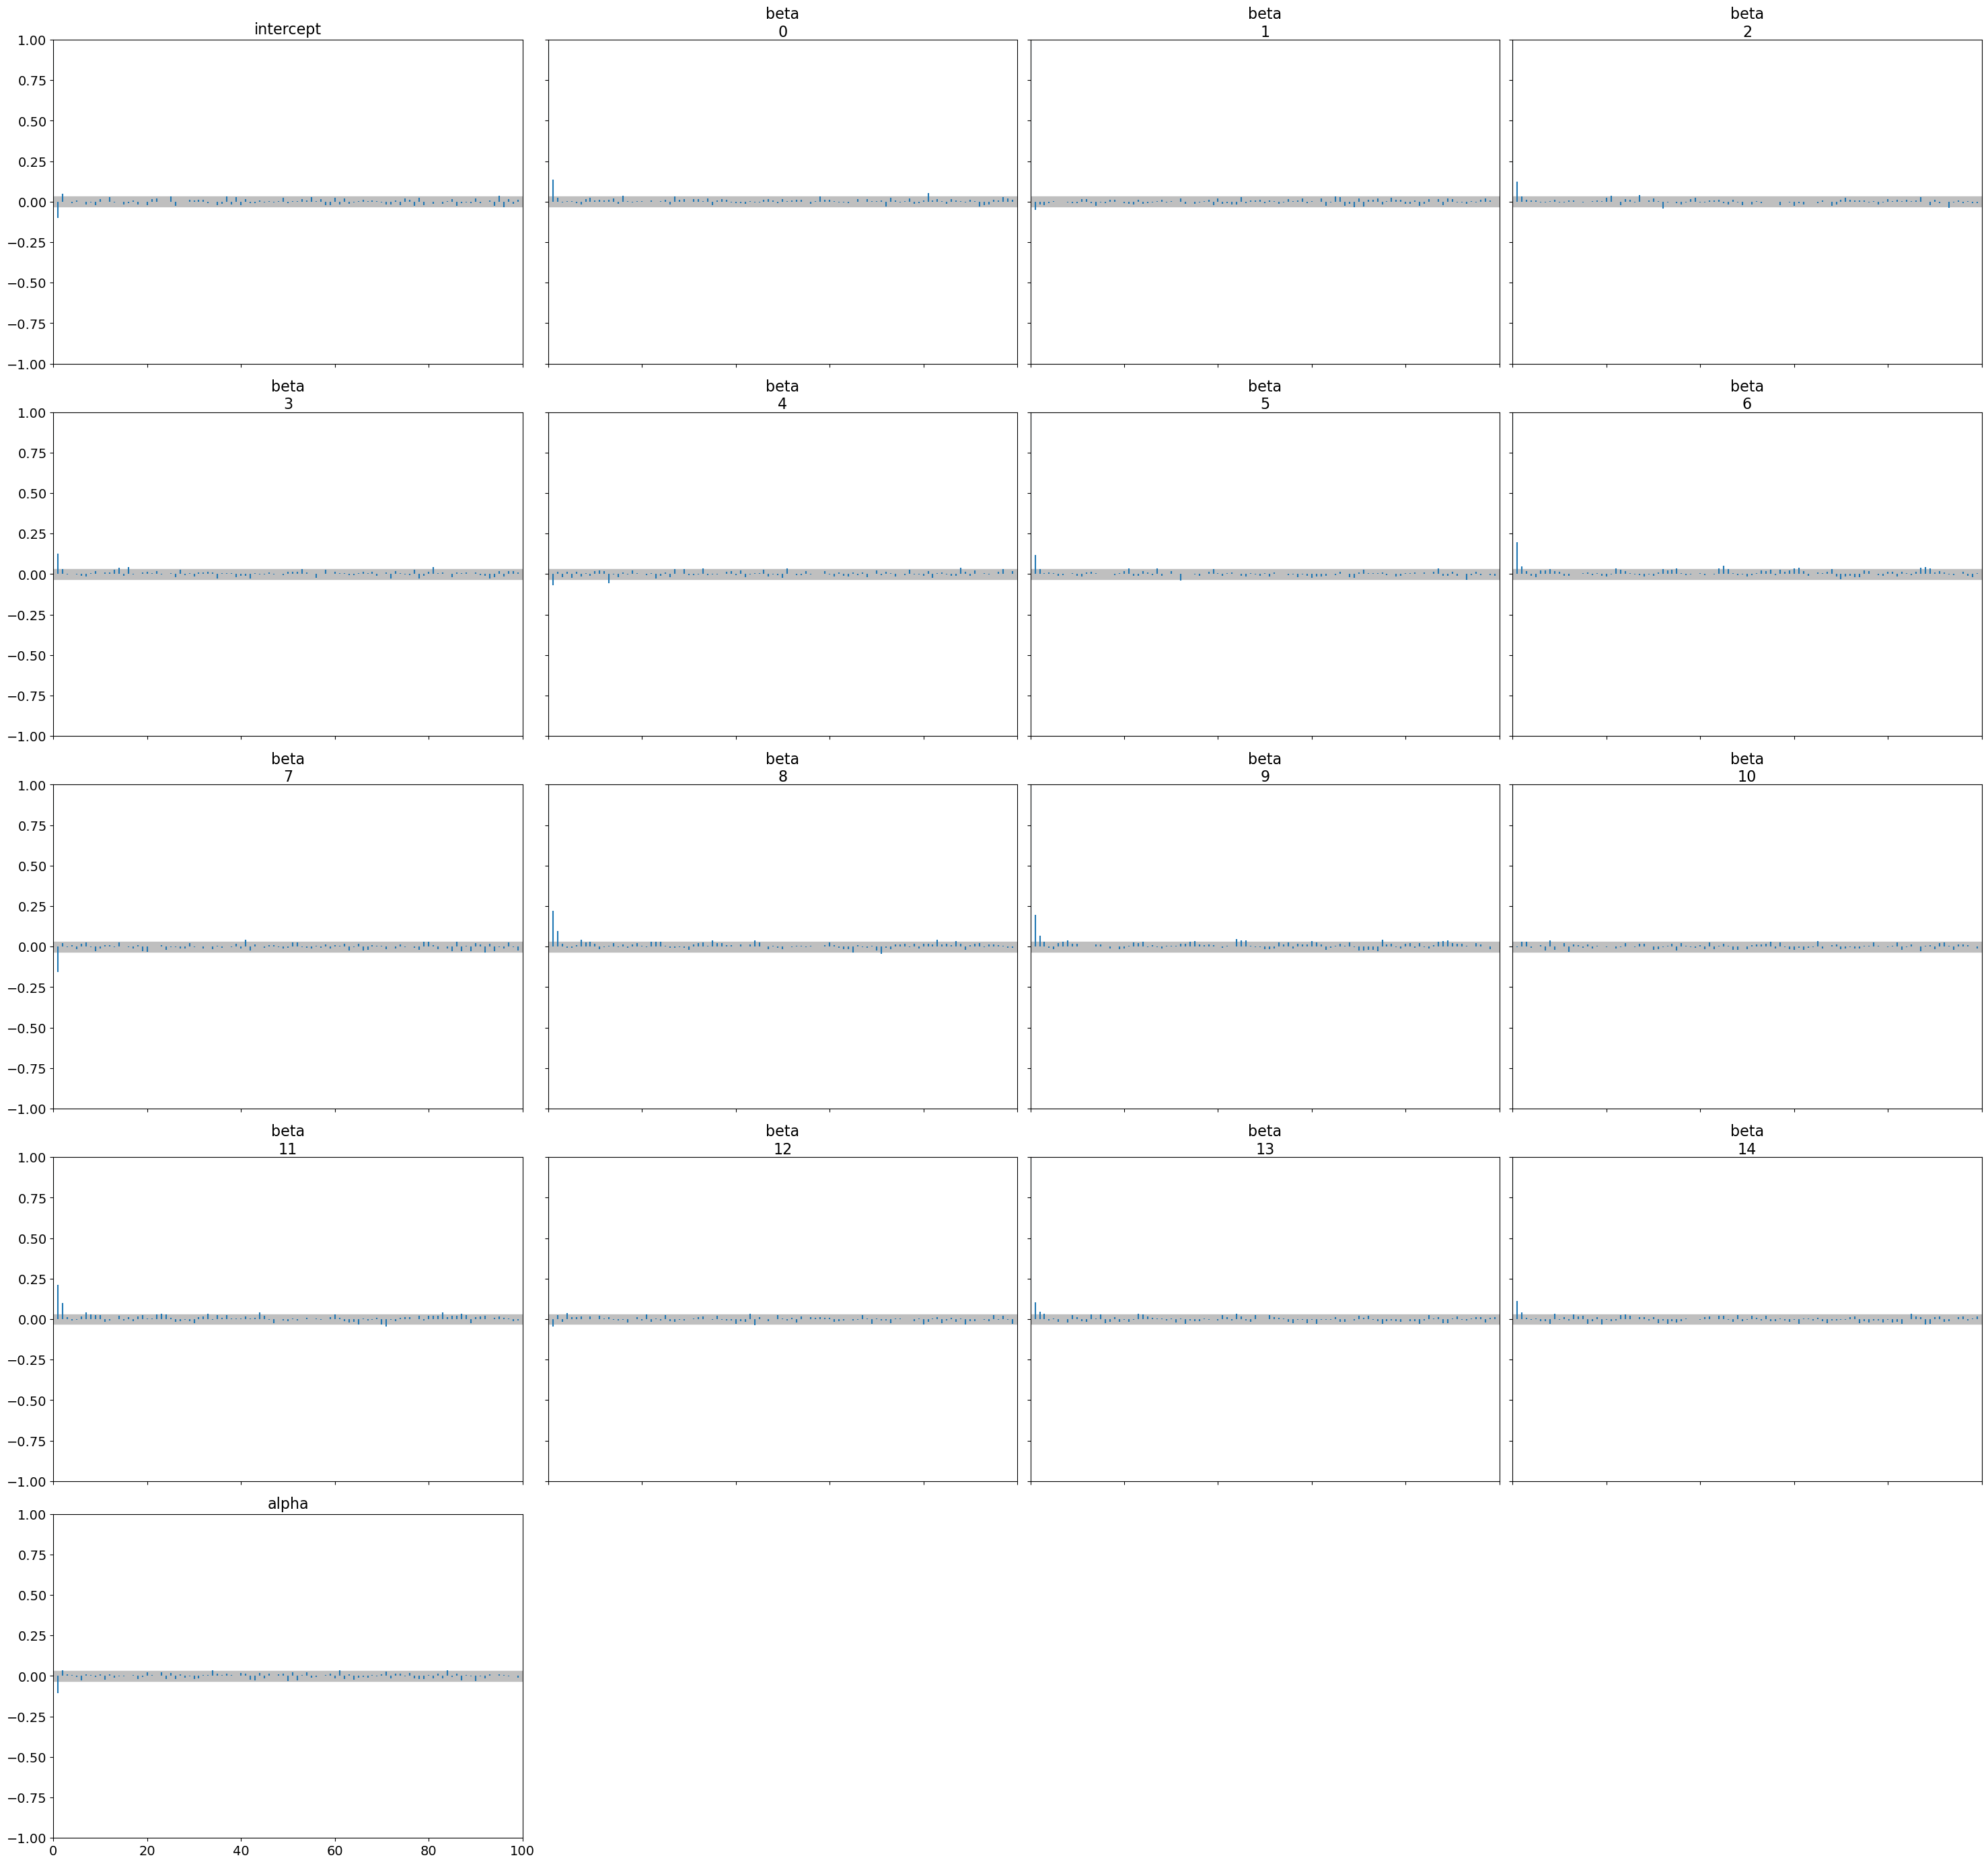

In [102]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

In [103]:
with free_sac_empathy:
    data.set_value(free_sac_features)
    sac_free_predictions = pm.sample_posterior_predictive(free_sac_empathy_trace)

In [104]:
data_sac_free_predictions = az.from_pymc3(model=free_sac_empathy, posterior_predictive=sac_free_predictions) 
pred_sac_probs = data_sac_free_predictions.posterior_predictive['y'].to_numpy().mean(axis=(0,1))

In [105]:
from sklearn.metrics import mean_squared_error
mean_squared_error(free_sac_features["empathy_level"].values, pred_sac_probs, squared= False)

12.975852666699872

__Feature selection__

In [107]:
from sklearn import feature_selection
statistics, p_values = feature_selection.f_regression(np.array(free_sac_features.loc[:, free_sac_features.columns != "empathy_level"]),pred_sac_probs)

In [108]:
pd.Series(statistics).rename(lambda i : REGRESSOR_SAC[i]).sort_values(ascending=False)

B_drift_00_sd       333.069781
Sigma_cross_mean    272.968813
Sigma_cross_sd      245.756555
amplitude           178.265957
B_drift_00_mean     127.353833
duration             82.124307
Sigma_11_sd          78.483802
B_drift_11_mean      58.934029
Sigma_11_mean        46.885439
Sigma_00_mean        27.400522
Sigma_00_sd          11.220517
B_cross_sd            9.928030
B_cross_mean          6.826222
angle                 4.467498
B_drift_11_sd         0.277782
dtype: float64

__Test__

In [106]:
free_fix_test_features = pd.DataFrame()
for filename in os.listdir("new_long_features/test"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr%2 == 0:
        free_fix_test_features = free_fix_test_features.append(get_fix_free_features(sub_nr, dset="test"))
free_fix_test_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,empathy_level
0,0.203973,-0.030062,0.253118,0.181649,0.085761,0.213300,10274.470966,415.509036,3336.580698,6037.146117,236.648508,2090.894892,0.058333,2.880000,2.840000,69
1,0.101654,-0.037299,0.319814,0.084866,0.083290,0.250989,2043.779496,-180.681676,7623.519836,845.245275,104.907107,3054.335274,0.200000,2.886667,2.861667,69
2,0.228204,-0.033831,0.140231,0.207488,0.076841,0.121299,11688.898645,426.008629,1785.570587,5871.147312,225.105912,953.770125,0.091667,2.915000,2.925000,69
3,0.063749,-0.022268,0.141876,0.049965,0.049184,0.117888,2374.620680,-114.201142,5228.715368,740.645194,108.855177,1606.864416,0.483333,2.894444,2.874444,69
4,0.191692,-0.015099,0.193863,0.169867,0.063342,0.153634,3698.279550,275.522889,23359.811904,2070.047120,153.855395,11612.180882,0.075000,2.882500,2.805000,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.103006,-0.055340,0.456427,0.084608,0.104147,0.383977,2925.471647,-198.531988,4036.553602,1724.369538,143.108796,2255.468560,0.083333,3.873333,3.733333,102
99,0.069593,-0.055876,0.449424,0.053514,0.089295,0.342737,2492.472888,-208.781809,7365.047312,756.030373,99.013611,2297.822576,0.475000,4.116316,3.885789,102
100,0.141121,-0.027930,0.173291,0.117958,0.074283,0.146190,4964.311526,288.100479,2699.444267,1701.202554,134.351298,894.460956,0.358333,3.996000,3.818667,102
101,0.064489,-0.024723,0.119524,0.048814,0.047896,0.093261,2854.080072,230.923562,2470.778841,714.953588,73.296140,594.881817,1.041667,3.993095,3.806429,102


In [130]:
with free_fix_empathy:
    pm.set_data({"free_fix_feat": free_fix_test_features})
    free_fix_test_trace = pm.sample_posterior_predictive(free_fix_empathy_trace, var_names = ["y"], extend_inferencedata=True,)

In [138]:
fix_free_ppc_data_test = az.from_pymc3(model=free_fix_empathy, posterior_predictive=free_fix_test_trace, predictions = True) 
free_fix_test_trace["y"]

TypeError: from_pymc3() got an unexpected keyword argument 'predictions'

In [109]:
free_sac_test_features = pd.DataFrame()
for filename in os.listdir("new_long_features/test"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr%2 == 0:
        free_sac_test_features = free_sac_test_features.append(get_sac_free_features(sub_nr, dset="test"))
free_sac_test_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,empathy_level
0,0.460251,-0.387592,0.541223,0.257178,0.213161,0.389579,19588.989421,711.029340,53637.476100,7475.181355,245.560374,19180.943137,19.114802,293.163777,0.033333,69
1,18.300322,1.455671,0.293063,9.882546,1.260709,0.254653,11883.832623,-214.072913,6497.952150,4834.389149,68.695211,2959.572645,-91.926035,565.319379,0.033333,69
2,0.938018,-0.028844,0.275041,0.765789,0.174636,0.210084,28683.416553,741.112290,34995.082510,14517.022741,368.365846,16813.885078,-59.743563,13.892444,0.041667,69
3,4.461779,-4.429512,4.708196,1.344141,0.810214,0.946625,47069.401987,734.756122,9597.108336,16955.254104,223.134343,4835.075580,89.246152,304.026315,0.033333,69
4,1.553461,-3.299022,8.963095,0.746522,0.938690,2.366350,41806.841213,-800.500689,29054.572215,16945.972070,359.316400,14010.952464,116.012376,139.089899,0.041667,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.419023,-0.063952,0.791162,0.577303,0.322214,0.641468,28527.296970,-619.711559,19198.828277,14957.821399,357.876768,11232.611794,-91.909152,60.033324,0.041667,102
63,0.225811,-0.076546,1.052349,0.202863,0.195119,0.888327,26102.625058,-600.363300,20535.428729,15162.891719,381.271407,12670.047710,67.380135,26.000000,0.033333,102
64,9.092172,-0.723828,0.431429,2.553470,0.623114,0.333341,18059.377340,-303.629135,16532.590375,7267.120068,152.893802,8096.634634,-82.602427,365.038354,0.041667,102
65,8.339244,-3.637590,2.536705,2.197634,1.288785,1.453300,26065.123111,-705.009818,26024.080368,10281.535914,252.314954,11209.961237,-61.444186,167.358896,0.033333,102


(4000, 1094)


In [158]:
data_sac_free_test_predictions = az.from_pymc3(model=free_sac_empathy, posterior_predictive=sac_free_test_predictions) 
pred_sac_test_probs = data_sac_free_predictions.posterior_predictive['y'].to_numpy().mean(axis=(0,1))

In [188]:
with free_fix_empathy:
    pm.set_data({"fixation_features": free_fix_test_features})
    fix_free_test_predictions = pm.sample_posterior_predictive(free_fix_empathy_trace)